# London housing prices - Regression model with Numerical and categorical data

London's housing market is dynamic and complex. In this project, we are working to figure out a price for selling newly built houses in a London suburb.

In this lab, we will be working with the following columns: 

- `price`: The price of the sale 
- `outcode`: First part of the postcode, grouping properties into broader geographic zones.
- `floorAreaSqM`: The area in square meters of the property.
- `latitude` & `longitude`: Geographic coordinates for mapping or location-based analysis.
- `bathrooms`: Number of bathrooms
- `bedrooms`: Number of bedrooms
- `livingRooms`: The number of living rooms in the property.
- `region`: The part of London

I've broken this project down into three parts. <br>
Before getting started with building models, let's run some quick hypothesis tests to find if there are any significant price changes between areas, then we can jump into what kind of models we can/will build with this dataset

## Table of contents
- [Step 1: Import libraries](#import-libraries)
- [Step 2: Load the data](#load-the-data)
- [Step 3: Confidence Intervals](#confidence-intervals)
    - [Confidence Intervals for Means](#ci-for-means)
- [Step 4: Hypothesis Testing](#hypothesis-testing)
- [Step 5: Understanding the influence of features](#influence-of-features)
- [Step 6: Creating a linear regression model](#simple-linear-regression)
- [Step 7: Interpreting your model](#interpreting-your-model)
- [Step 8: Including categorical data](#cat-data)
- [Step 9: Train your model](#train-your-model)
    - [Improving the model](#improving-the-model)

# Part 1
<a id="import-libraries"></a>

## Step 1: Import libraries
Let's begin by importing all the libraries needed for our project.

In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

<a id="load-the-data"></a>

## Step 2: Load the data
Next up, we load the data in "df" and make sure it is correctly loaded. Run the cell below to load the data. 

In [3]:
df = pd.read_csv("london_house_price_2018.csv")
df.head(2)

,fullAddress,postcode,outcode,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,tenure,propertyType,currentEnergyRating,price
0,"Flat 1, White Rose Court, Widegate Street, Lon...",E1 7ES,E1,51.517972,-0.078028,2.0,2.0,73.0,1.0,Leasehold,Purpose Built Flat,D,623000
1,"Flat 5, White Rose Court, Widegate Street, Lon...",E1 7ES,E1,51.517972,-0.078028,1.0,2.0,50.0,1.0,Leasehold,Converted Flat,E,575000


<a id="confidence-intervals"></a>

## Step 3: Confidence Intervals

<a id="ci-for-means"></a>

### Confidence Intervals for Means

The average price per square meter is crucial for understanding property values and comparing homes of different sizes. By constructing a confidence interval, we will have a reliable estimate, offering clearer insight into how much houses might be worth.

In [4]:
# Add the price_per_sqm column
df["price_per_sqm"] = df["price"] / df["floorAreaSqM"]

# calculate the sample mean
mean_price_sqm = df["price_per_sqm"].mean()

# calculate the sample standard deviation
std_price_sqm = df["price_per_sqm"].std()

# calculate the sample size
n = df["price_per_sqm"].count()

# calculate the scale
SEM = std_price_sqm / np.sqrt(n)

# Calculate the confidence interval using norm.interval
interval = stats.norm.interval(0.95, loc=mean_price_sqm, scale=SEM)

print("Mean price per square meter:", mean_price_sqm)
print("95% confidence interval: (", interval[0], ",", interval[1], ")")

Mean price per square meter: 7502.891480118485
95% confidence interval: ( 7463.1124828845495 , 7542.67047735242 )


<a id="hypothesis-testing"></a>

## Step 4: Hypothesis Testing
The price per square meter reflects, among other things, location desirability and property value. Let's look at the two most popular areas, if we were to build new houses in the Dulwich or Wimbledon area. Is the cost for houses the same in these areas, or does the price per square meter differ significantly between them? <br>
Let's answer the question using a confidence interval with 5% significance.

Houses in Dulwich (`outcode` equals "SE21").

Houses in the Wimbledon area (`outcode` equals "SW19").

In [5]:
# create a new DataFrame that includes only Dulwich samples
dulwich_df = df[df["outcode"]=="SE21"]

# create another DataFrame including only Wimbledon samples
wimbledon_df = df[df["outcode"]=="SW19"]

# find the p-value and test statistic for this two-sampled t-test
test_results = stats.ttest_ind(dulwich_df["price_per_sqm"], wimbledon_df["price_per_sqm"])

print(test_results)
t_stat = test_results[0]
p_value = test_results[1]

print("T-statistic:", t_stat)
print("P-value:", p_value)

TtestResult(statistic=-5.772630665662497, pvalue=9.7521016289875e-09, df=1298.0)
T-statistic: -5.772630665662497
P-value: 9.7521016289875e-09


With this, we can conclude with 95% confidence, we reject the statement that price per square meter is the same in different areas. <br>Hence, the location of the building plays a big role in the overall cost of the houses.

# Part 2
Now, I would like to estimate the price of the houses that someone would want to sell. In this part, we will use a linear regression model to do this.

<a id="influence-of-features"></a>

## Step 5: Understanding the influence of features

### Create scatter plots

In order to predict the price of the house, we need to first understand which are the most relevant features to do so. `"floorAreaSqM"` is a great candidate, but we want to make sure it is the most important one in our dataset. So let's begin by creating scatter plots for all (non-categorical) numeric features.


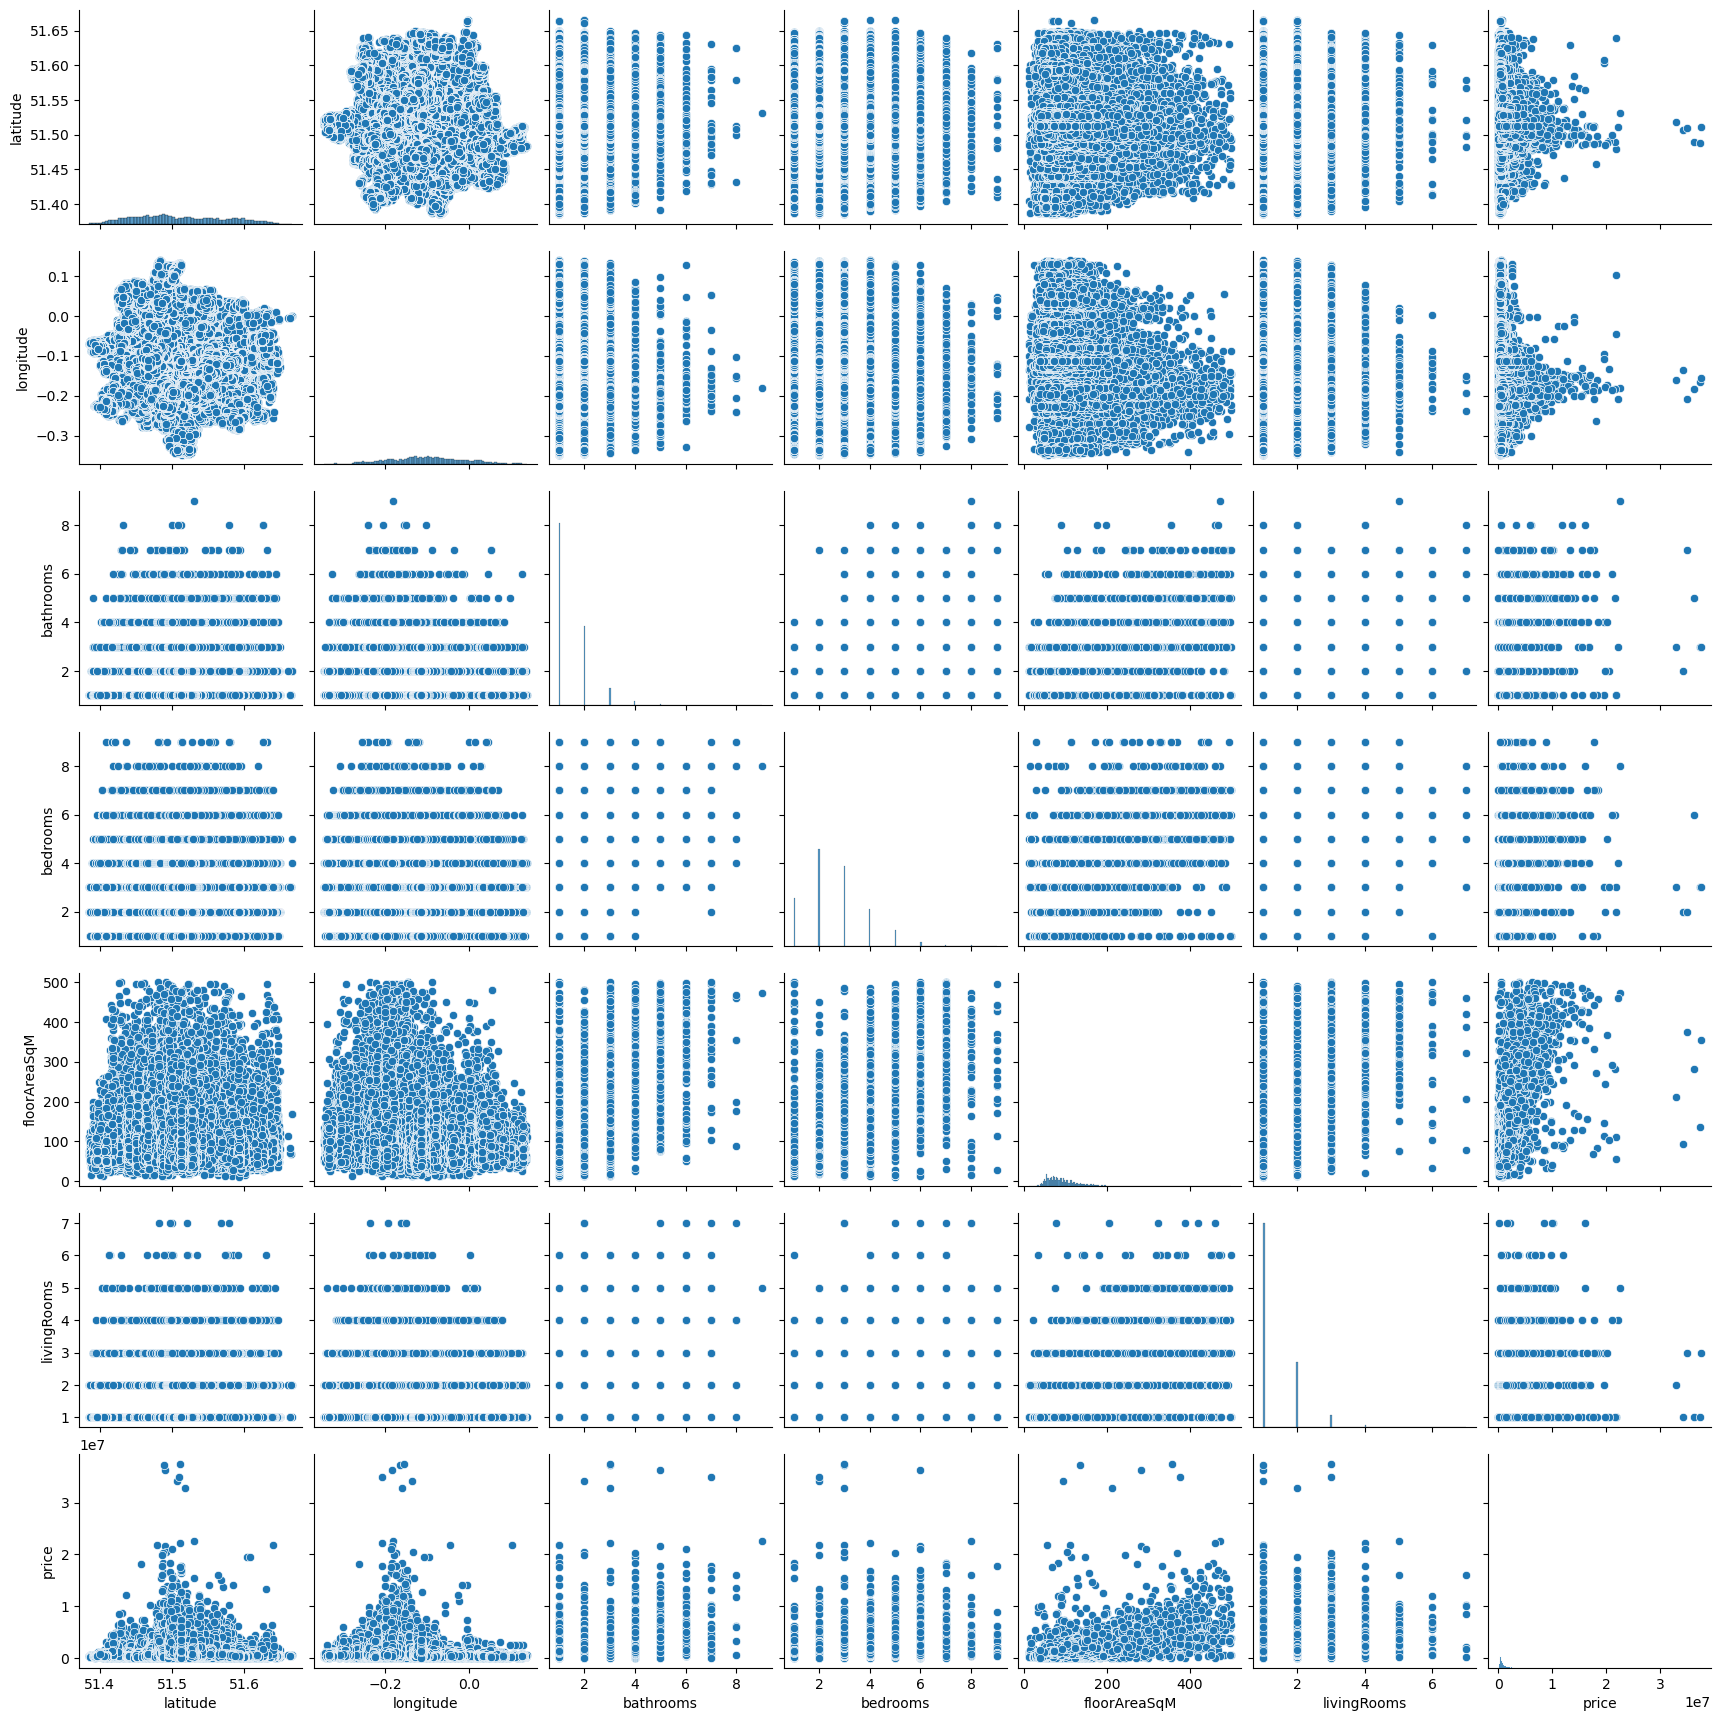

In [7]:
# Define a list of numerical features
numerical_features = ["latitude", "longitude", "bathrooms", "bedrooms", "floorAreaSqM",
                      "livingRooms", "price"]

# Create a pairplot with the DataFrame containing only numerical features
sns.pairplot(df[numerical_features])
plt.show()

From the scatterplots, it is not completely obvious which feature is the best, as none of them really stand out. Let's try calculating the correlations to numerically evaluate which of the features might be the best to use.

### Calculate the correlation

In [8]:
df[numerical_features].corr()

,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,price
latitude,1.000000,-0.051308,0.038546,0.037725,0.042568,0.070444,0.008352
longitude,-0.051308,1.000000,-0.207145,-0.086213,-0.165193,-0.055058,-0.234584
bathrooms,0.038546,-0.207145,1.000000,0.557272,0.663587,0.375192,0.550484
bedrooms,0.037725,-0.086213,0.557272,1.000000,0.802344,0.542835,0.429837
floorAreaSqM,0.042568,-0.165193,0.663587,0.802344,1.000000,0.626097,0.646681
livingRooms,0.070444,-0.055058,0.375192,0.542835,0.626097,1.000000,0.383612
price,0.008352,-0.234584,0.550484,0.429837,0.646681,0.383612,1.000000


It seems that the first intuition is right! If working with only one predictor, `"floorAreaSqM"` is the way to go. <br>(Again, not the best as it only explains 64% of the full estimate, but it's a start!)

<a id="simple-linear-regression"></a>

## Step 6: Creating a linear regression model
Now we are ready to define and train the linear regression model. Let's create our first model that uses `"floorAreaSqM"` as the independent variable, and `"price"` as the dependent variable.

In [9]:
# define the dependent variable
Y = df["price"]

# define the DataFrame with the independent variable and the constant term
X = sm.add_constant(df["floorAreaSqM"])

# create the model
model = sm.OLS(Y, X)

# fit the model
results = model.fit()

# print the model summary
print(results.summary()) 

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                 5.801e+04
Date:                Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:14:25   Log-Likelihood:            -1.2037e+06
No. Observations:               80703   AIC:                         2.407e+06
Df Residuals:                   80701   BIC:                         2.407e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.171e+05   5349.807    -59.277   

<a id="interpreting-your-model"></a>

## Step 7: Interpreting our Model

Before even considering using the model, it is a good idea to stop and analyze our results. We can do this by looking at the R-squared, the coefficient values, and their p-values (`P>|t|`).

I personally prefer to use a visual aid, to get a clear understanding!

<Axes: xlabel='floorAreaSqM', ylabel='price'>

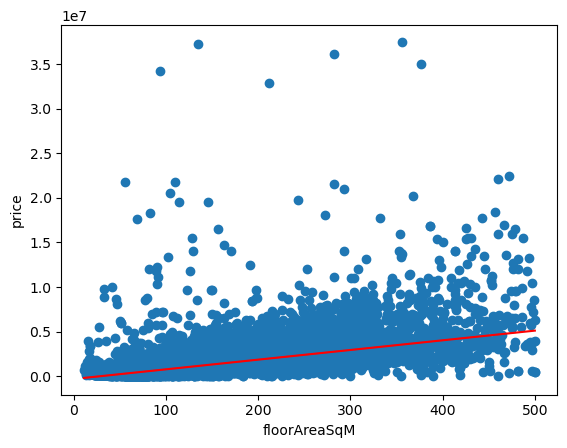

In [13]:
# get the parameter values from the model
m = results.params['floorAreaSqM']
b = results.params["const"]

# create the scatter plot
plt.scatter(df["floorAreaSqM"], df["price"])

# calculate the line of best fit 
# "y = mx + b"
line = m * df["floorAreaSqM"] + b

# assign "price" as the y-label
plt.ylabel("price")

# add the line of best fit to the scatter plot
sns.lineplot(x=df["floorAreaSqM"], y=line, color="red")

# Part 3
At this point, our model only has a 41% accuracy of the predicting the price. Let's try to improve the model using more variables now!

<a id="cat-data"></a>

## Step 8: Including categorical data
We already know that the borough, where the property is located, influences the price. We confirmed this in 'Part 1' of this project with a hypothesis test. We will definitely include this information in our model. 

In [20]:
# use "floorAreaSqM" and "outcode" as predictors
predictors = ["floorAreaSqM", "outcode"]

# get the dummy variables for the region column
features_with_dummies = pd.get_dummies(df[predictors],
                                drop_first=True,
                                dtype=int)

# explore the DataFrame
features_with_dummies.head(2)

,floorAreaSqM,outcode_E10,outcode_E11,outcode_E12,outcode_E13,outcode_E14,outcode_E15,outcode_E16,outcode_E17,outcode_E18,...,outcode_WC1N,outcode_WC1R,outcode_WC1V,outcode_WC1X,outcode_WC2A,outcode_WC2B,outcode_WC2E,outcode_WC2H,outcode_WC2N,outcode_WC2R
0,73.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,50.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now that our features are ready, create and train our multiple linear regression model!
<a id="train-your-model"></a>

## Step 8: Train our model

With "floorAreaSqM", "outcode"

In [18]:
# get the dependent variable
Y = df["price"]

# add the constant term to the independent variables
X = sm.add_constant(features_with_dummies)

# create the model
model = sm.OLS(Y, X)

# fit the model
results = model.fit()

# print the summary
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     653.6
Date:                Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:46:30   Log-Likelihood:            -1.1915e+06
No. Observations:               80703   AIC:                         2.383e+06
Df Residuals:                   80539   BIC:                         2.385e+06
Df Model:                         163                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.193e+05   2.63e+04     -8.350   

<br>
Adding the dummy variables improved the R-squared of the base model, going from 0.418 to 0.569, which is almost a 25% increase!

Do you think you could improve the model by adding some other features?

<a id="improving-the-model"></a>

### Improving the Model

In the previous Part, we have looked at the correlations of all variables and determined that `"floorAreaSqM"` correlates the strongest with `"price"`. The second strongest is the `"bathrooms"` variable. Let's create a new model below, where we use both of these variables in addition to the dummy variables from the `"outcode"` categorical variable.

In [19]:
# use "floorAreaSqM", "bathrooms" and "outcode" as predictors
predictors = ["floorAreaSqM", "bathrooms", "outcode"]

# get the dummy variables for the region column
features_with_dummies = pd.get_dummies(df[predictors], drop_first=True, dtype=int)

# add the constant term
X = sm.add_constant(features_with_dummies)

# get the target variable
Y = df["price"]

# create the model
model = sm.OLS(Y, X)

# fit the model
results = model.fit()

# print the model summary
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     666.9
Date:                Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:49:26   Log-Likelihood:            -1.1909e+06
No. Observations:               80703   AIC:                         2.382e+06
Df Residuals:                   80538   BIC:                         2.384e+06
Df Model:                         164                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.213e+05   2.62e+04    -12.248   

#### As you can see, the R-squared value improved further to 0.576. Let's try some other variables to see if we can get the R-squared even higher!

In [21]:
predictors = ["floorAreaSqM", "bathrooms","livingRooms","outcode","bedrooms","longitude"]

# get the dummy variables for the region column
features_with_dummies = pd.get_dummies(df[predictors], drop_first=True, dtype=int)

# add the constant term
X = sm.add_constant(features_with_dummies)

# get the target variable
Y = df["price"]

# create the model
model = sm.OLS(Y, X)

# fit the model
results = model.fit()

# print the model summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     669.7
Date:                Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:51:29   Log-Likelihood:            -1.1904e+06
No. Observations:               80703   AIC:                         2.381e+06
Df Residuals:                   80535   BIC:                         2.383e+06
Df Model:                         167                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.168e+05   2.96e+04    -10.721   

# Congratulations on making it until the end of this project. <br> You are most welcome to play around with this code, add/drop features and test the correlation of it with the total cost of the houses. <br><br>Hope you enjoyed it! 